In [1]:
import os
import gc
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import glob

In [2]:
import string
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim import utils
import gensim.parsing.preprocessing as gsp

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Logistic Regression

In [3]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

FileNotFoundError: ignored

In [ ]:
train2.toxic = train2.toxic.round().astype(int)
train = pd.concat([train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000)
    ])
#rate=10
#train = train[::rate]
train.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
valid.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [ ]:
test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [ ]:
print("Validation data set size:",valid.shape)
print("Test data set size:",test.shape)
print("Training data set size:",train.shape)

Validation data set size: (8000, 4)
Test data set size: (63812, 3)
Training data set size: (435775, 2)


In [ ]:
def get_language(text):
    return Detector("".join(x for x in text if x.isprintable()),quiet=True).languages[0].name

In [ ]:
pip install pyicu

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pycld2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from polyglot.detect import Detector
from polyglot.utils import pretty_list

In [ ]:
train['language'] = train["comment_text"].apply(get_language)

In [ ]:
train.head()

,comment_text,toxic,language
0,Explanation\nWhy the edits made under my usern...,0,English
1,D'aww! He matches this background colour I'm s...,0,English
2,"Hey man, I'm really not trying to edit war. It...",0,English
3,"""\nMore\nI can't make any real suggestions on ...",0,English
4,"You, sir, are my hero. Any chance you remember...",0,English


In [ ]:
train['toxic'].value_counts()

0    302165
1    133610
Name: toxic, dtype: int64

In [ ]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()
 
filters = [
           gsp.strip_tags, #remove tags 
           gsp.strip_punctuation, #remove punctuation
           gsp.strip_multiple_whitespaces, #standarized the spaces 
           gsp.strip_numeric,
           gsp.remove_stopwords, #stop words  
           gsp.strip_short, 
           gsp.stem_text #stemming 
          ]

def clean_text(s):
    s = str(s).lower() 
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
train[train.language=='xx']

,comment_text,toxic,language
208323,ⲛⲁⲓ ⲛⲉ ⲕⲱⲧⲉ ⲃ̅ ⳽ ϣⲟ ̀ⲛϣⲟ ϣⲗⲱⲗ Ϧⲉⲛ ⲇ̅ⲏ̅ ϩⲁⲛⲕⲁϩⲓ...,0,xx


In [ ]:
#clean the text first 
train['comment_text'].fillna("unknown", inplace=True)
train["comment_text"] = train["comment_text"].apply(clean_text)

In [ ]:
#vectorization of the model 
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, strip_accents='unicode', use_idf=1,smooth_idf=1, sublinear_tf=1)

pipeline = Pipeline([
    ('tfidf', vec),
    ('logreg', LogisticRegression(penalty='elasticnet')),
])

parameters = {
    'tfidf__max_features': [None, 1000, 5000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or unigrams + bigrams
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : np.logspace(-4, 4, 20),
    'logreg__solver' : ['liblinear'],
}

## ROC AUC

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,scoring=['roc_auc'],cv=cv, n_iter=10, refit='roc_auc')

In [ ]:
%%time 

random_search.fit(train["comment_text"], train['toxic']);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.6min finished


CPU times: user 50.5 s, sys: 15.4 s, total: 1min 5s
Wall time: 25min 9s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2),
                                                              smooth_idf=1,
                                                              strip_accents='unicode',
                                                              sublinear_tf=1,
                                                              tokenizer=<function tokenize at 0x7f58f1c58950>,
                                                              use_idf=1)),
                                             ('logreg',
                                              LogisticRegression(penalty='elasticnet'))]),
                   n_jobs=-1,
                   param_distributions={'logreg_...
       2.33572147e-01, 6.15848211e-01, 1.62377674e

In [ ]:
pd.DataFrame(random_search.cv_results_).sort_values('mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__ngram_range,param_tfidf__max_features,param_logreg__solver,param_logreg__penalty,param_logreg__C,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
4,30.455096,0.513214,4.613164,0.167538,"(1, 1)",None,liblinear,l2,11.288379,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.961174,0.961777,0.960914,0.962070,0.962167,0.961621,0.000495,1
1,72.465097,0.581290,8.127536,0.209303,"(1, 2)",5000,liblinear,l1,4.281332,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.956670,0.958465,0.957093,0.957823,0.957588,0.957528,0.000615,2
8,72.120963,1.113640,7.737611,0.447946,"(1, 2)",5000,liblinear,l2,11.288379,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.956519,0.958322,0.956971,0.957640,0.957450,0.957380,0.000612,3
3,20.856770,0.328227,4.121931,0.129332,"(1, 1)",None,liblinear,l2,0.012743,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.938749,0.939760,0.938732,0.939524,0.939599,0.939273,0.000441,4
7,32.480151,2.342574,4.590446,0.399415,"(1, 1)",50000,liblinear,l1,1438.449888,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.932585,0.929652,0.930676,0.932185,0.931918,0.931403,0.001083,5
2,20.950086,0.230521,4.058962,0.150901,"(1, 1)",1000,liblinear,l2,11.288379,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.929992,0.931431,0.931883,0.929885,0.930177,0.930673,0.000821,6
5,20.622097,0.267385,4.826306,0.109316,"(1, 1)",50000,liblinear,l1,0.012743,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.920500,0.921932,0.921263,0.922115,0.922961,0.921754,0.000829,7
6,114.550460,1.735610,9.561850,0.375864,"(1, 2)",None,liblinear,l1,10000.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.918208,0.918548,0.920961,0.920916,0.917356,0.919198,0.001474,8
0,66.268457,0.414798,7.669685,0.309653,"(1, 2)",5000,liblinear,l2,0.000695,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.913271,0.914301,0.913128,0.914203,0.914267,0.913834,0.000521,9
9,66.423186,0.404857,7.311590,0.362426,"(1, 2)",5000,liblinear,l2,0.000264,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.909208,0.910173,0.908891,0.910062,0.910124,0.909692,0.000535,10


### Validation dataset fitting
- With AUC model

In [ ]:
#valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
valid['comment_text'].fillna("unknown", inplace=True)
valid["comment_text"] = valid["comment_text"].apply(clean_text)

#score the validation dataset
y_valid = valid['toxic']
y_pred_valid = random_search.best_estimator_.predict_proba(valid["comment_text"])
# print('Testing accuracy %s' % accuracy_score(y_valid, y_pred_valid))
# print('Testing F1 score: {}'.format(f1_score(y_valid, y_pred_valid, average='weighted')))
print('Validation AUC score %s' % roc_auc_score(y_valid, y_pred_valid[:, 1]))

Validation AUC score 0.6708306613346784


In [ ]:
test["comment_text"] = test["content"].apply(clean_text)

#score the submission file 
y_pred = random_search.best_estimator_.predict_proba(test["comment_text"])

#load the sample submission file 
sample_sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

submid = pd.DataFrame({'id': sample_sub["id"]})
submission = pd.concat([submid,test.comment_text, pd.DataFrame(y_pred[:, 1],columns=['toxic'])], axis=1)
submission.head()

,id,comment_text,toxic
0,0,doctor adlı viki başlığına doctor olarak bir v...,0.039370
1,1,вполне возможно пока вижу необходимости выделя...,0.036006
2,2,quindi sei uno quelli conservativi che preferi...,0.146568
3,3,malesef gerçekleştirilmedi ancak şöyle bir şei...,0.018748
4,4,resim seldabagcan jpg resmind kaynak sorunu re...,0.026308


In [ ]:
submission.toxic = submission.toxic.round().astype(int)

In [ ]:
submission.toxic.value_counts()

0    63143
1      669
Name: toxic, dtype: int64

In [ ]:
submission.head(10)

,id,comment_text,toxic
0,0,doctor adlı viki başlığına doctor olarak bir v...,0
1,1,вполне возможно пока вижу необходимости выделя...,0
2,2,quindi sei uno quelli conservativi che preferi...,0
3,3,malesef gerçekleştirilmedi ancak şöyle bir şei...,0
4,4,resim seldabagcan jpg resmind kaynak sorunu re...,0
5,5,truc plu import dan tirad est quand même mon a...,0
6,6,caro editor encontramo problema edição que fez...,0
7,7,skate uno lo deport favorito tierra skate pued...,0
8,8,doi bienvenida est usuari gusta confrontars lo...,0
9,9,notablement tendencioso habla cuando tupac ame...,0


# DistilBERT

In [ ]:
!pip install -U transformers

     |████████████████████████████████| 3.5 MB 2.3 MB/s eta 0:00:01     |█▋                              | 184 kB 2.3 MB/s eta 0:00:02
     |████████████████████████████████| 67 kB 3.7 MB/s  eta 0:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.17
    Uninstalling huggingface-hub-0.0.17:
      Successfully uninstalled huggingface-hub-0.0.17
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.12.1 requires huggingface-hub<0.1.0,>=0.0.14, but you have huggingface-hub 0.4.0 which is incompatible.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 4.16.0 which is incompatible.


In [ ]:
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
import tokenizers
from tokenizers import BertWordPieceTokenizer

2022-01-28 05:41:10.547882: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-28 05:41:10.547988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
#     text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()

def text_process(text):
    ws = text.split(' ')
    if(len(ws)>160):
        text = ' '.join(ws[:160]) + ' ' + ' '.join(ws[-32:])
    return text

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    print('encoding with', tokenizer)
    
    # for transformers 3.5
    if isinstance(tokenizer, transformers.DistilBertTokenizer) or \
        isinstance(tokenizer, transformers.DistilBertTokenizerFast):
    #     tokenizer.enable_truncation(max_length=maxlen)
    #     tokenizer.enable_padding(max_length=maxlen)
        all_ids = []

        for i in tqdm(range(0, len(texts), chunk_size)):
            text_chunk = texts[i:i+chunk_size].tolist()
    #         encs = tokenizer.encode_batch(text_chunk)
            encs = tokenizer(text_chunk, padding='max_length', truncation=True, max_length=maxlen)
    #         all_ids.extend([enc.ids for enc in encs])
            all_ids.extend(encs['input_ids']) 
    elif isinstance(fast_tokenizer, tokenizers.implementations.bert_wordpiece.BertWordPieceTokenizer): 
        tokenizer.enable_truncation(max_length=maxlen)
        tokenizer.enable_padding(max_length=maxlen)
        all_ids = []

        for i in tqdm(range(0, len(texts), chunk_size)):
            text_chunk = texts[i:i+chunk_size].tolist()
            encs = tokenizer.encode_batch(text_chunk)
            all_ids.extend([enc.ids for enc in encs])

    
    return np.array(all_ids)

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')

save_path = '/kaggle/working/distilbert_base_cased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)
fast_tokenizer = tokenizer

# "faster as the tokenizers from transformers because they are implemented in Rust."
# fast_tokenizer = BertWordPieceTokenizer('distilbert_base_cased/vocab.txt', lowercase=False)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

## TPU Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-01-28 05:41:19.970381: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-28 05:41:19.973487: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-28 05:41:19.973530: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-28 05:41:19.973568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (20212dc39723): /proc/driver/nvidia/version does not exist
2022-01-28 05:41:19.977413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [ ]:
# Configuration
AUTO = tf.data.experimental.AUTOTUNE
SHUFFLE = 2048
EPOCHS1 = 20
EPOCHS2 = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
VERBOSE = 2

In [ ]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [ ]:
train2.toxic = train2.toxic.round().astype(int)
train = pd.concat([train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000)
    ])
#rate=10
#train = train[::rate]
train.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
def len_sent(data):
    return len(data.split())
train["num_words_comment_text"] = train["comment_text"].apply(lambda x : len_sent(x))
#sns.kdeplot(train[train["toxic"] == 0]["num_words_comment_text"].values, shade = True, color = "red", label='non_toxity')
#sns.kdeplot(train[train["toxic"] == 1]["num_words_comment_text"].values, shade = True, color = "blue", label='toxity')

y_train = train['toxic'].values



In [ ]:
train.head()

,comment_text,toxic,num_words_comment_text
0,Explanation\nWhy the edits made under my usern...,0,43
1,D'aww! He matches this background colour I'm s...,0,17
2,"Hey man, I'm really not trying to edit war. It...",0,42
3,"""\nMore\nI can't make any real suggestions on ...",0,113
4,"You, sir, are my hero. Any chance you remember...",0,13


In [ ]:
del train['toxic']; gc.collect()

23

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'] = train['comment_text'].apply(lambda x: text_process(x))
x_train = fast_encode(train['comment_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)

encoding with PreTrainedTokenizerFast(name_or_path='distilbert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/1703 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

In [ ]:

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(SHUFFLE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

del x_train; gc.collect()


valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
valid['comment_text'] = valid.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid['comment_text'] = valid['comment_text'].apply(lambda x: text_process(x))
x_valid = fast_encode(valid['comment_text'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
y_valid = valid['toxic'].values

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

del x_valid; gc.collect()

encoding with PreTrainedTokenizerFast(name_or_path='distilbert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/32 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

0

## Callbacks

In [ ]:
lrs = ReduceLROnPlateau(monitor='val_auc', mode ='max', factor = 0.7, min_lr= 1e-7, verbose = 1, patience = 2)
es1 = EarlyStopping(monitor='val_auc', mode='max', verbose = 1, patience = 5, restore_best_weights=True)
es2 = EarlyStopping(monitor='auc', mode='max', verbose = 1, patience = 1, restore_best_weights=True)
callbacks_list1 = [lrs,es1]
callbacks_list2 = [lrs,es2]

## Build Model

In [ ]:
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.4)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    return model

## Load model in TPU

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

2022-01-28 05:44:30.402770: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 134734080 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
CPU times: user 31.4 s, sys: 11 s, total: 42.4 s
Wall time: 41.8 s


## Run Model

In [ ]:
# not train on order to save memory
n_steps = len(y_train) // (BATCH_SIZE*8)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS1,
    callbacks=callbacks_list1,
    verbose=VERBOSE
)

del train_dataset; gc.collect()

Epoch 1/20
425/425 - 80s - loss: 0.1794 - auc: 0.9181 - accuracy: 0.9335 - val_loss: 0.4421 - val_auc: 0.7393 - val_accuracy: 0.8515
Epoch 2/20
425/425 - 29s - loss: 0.1155 - auc: 0.9669 - accuracy: 0.9560 - val_loss: 0.4142 - val_auc: 0.7794 - val_accuracy: 0.8531
Epoch 3/20
425/425 - 29s - loss: 0.1071 - auc: 0.9734 - accuracy: 0.9581 - val_loss: 0.4650 - val_auc: 0.7968 - val_accuracy: 0.8474
Epoch 4/20
425/425 - 29s - loss: 0.1296 - auc: 0.9652 - accuracy: 0.9438 - val_loss: 0.5881 - val_auc: 0.7819 - val_accuracy: 0.8469
Epoch 5/20
425/425 - 29s - loss: 0.0365 - auc: 0.9972 - accuracy: 0.9858 - val_loss: 3.0710 - val_auc: 0.7422 - val_accuracy: 0.2985

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.9999998231651255e-06.
Epoch 6/20
425/425 - 29s - loss: 3.0698e-05 - auc: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.6471 - val_auc: 0.7229 - val_accuracy: 0.2648
Epoch 7/20
425/425 - 29s - loss: 0.0486 - auc: 0.9967 - accuracy: 0.9842 - val_loss: 1.2826 - val_auc: 0.5525 - 

74904

In [ ]:
train_history_df = pd.DataFrame.from_dict(train_history.history)
train_history_df

,loss,auc,accuracy,val_loss,val_auc,val_accuracy,lr
0,0.179436,0.918078,0.933511,0.442107,0.739305,0.851500,0.000010
1,0.115536,0.966858,0.956048,0.414176,0.779395,0.853125,0.000010
2,0.107104,0.973442,0.958125,0.465013,0.796806,0.847375,0.000010
3,0.129646,0.965169,0.943842,0.588071,0.781861,0.846875,0.000010
4,0.036541,0.997246,0.985809,3.071001,0.742225,0.298500,0.000010
5,0.000031,0.000000,1.000000,3.647092,0.722911,0.264750,0.000007
6,0.048624,0.996681,0.984228,1.282631,0.552469,0.846375,0.000007
7,0.004143,0.767062,0.999265,0.758686,0.697479,0.846500,0.000005


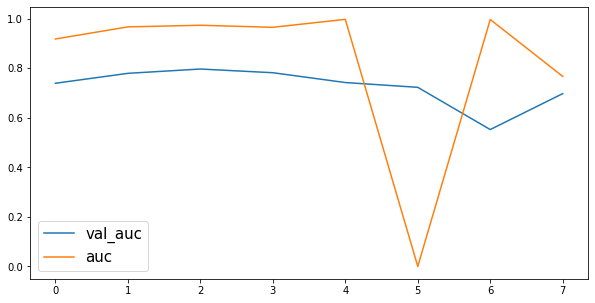

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_history_df['val_auc'], label='val_auc')
plt.plot(train_history_df['auc'], label='auc')
plt.legend(fontsize=15)

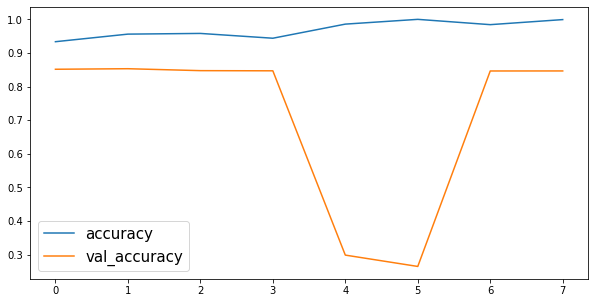

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_history_df['accuracy'], label='accuracy')
plt.plot(train_history_df['val_accuracy'], label='val_accuracy')
plt.legend(fontsize=15)

In [ ]:
n_steps = len(y_valid) // (BATCH_SIZE)

train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS2,
    callbacks=callbacks_list2,
    verbose=VERBOSE
)

Epoch 1/4
62/62 - 4s - loss: 0.3297 - auc: 0.8316 - accuracy: 0.8613
Epoch 2/4
62/62 - 30s - loss: 0.2623 - auc: 0.9027 - accuracy: 0.8855
Epoch 3/4
62/62 - 4s - loss: 0.2278 - auc: 0.9298 - accuracy: 0.8989
Epoch 4/4
62/62 - 4s - loss: 0.1925 - auc: 0.9522 - accuracy: 0.9157


In [ ]:
train_history2_df = pd.DataFrame.from_dict(train_history_2.history)
train_history2_df

,loss,auc,accuracy,lr
0,0.329728,0.831570,0.861265,0.000005
1,0.262303,0.902705,0.885544,0.000005
2,0.227849,0.929754,0.898882,0.000005
3,0.192479,0.952168,0.915650,0.000005


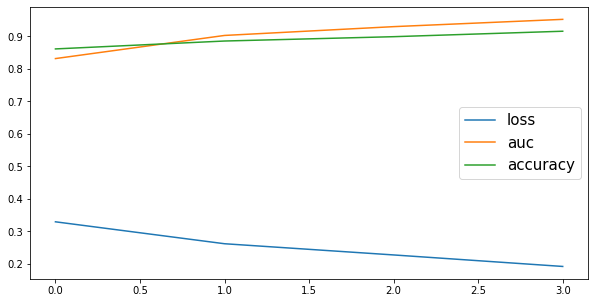

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_history2_df['loss'], label='loss')
plt.plot(train_history2_df['auc'], label='auc')
plt.plot(train_history2_df['accuracy'], label='accuracy')
plt.legend(fontsize=15)

In [ ]:
x_test = fast_encode(test['content'].astype(str), fast_tokenizer, maxlen=MAX_LEN)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

encoding with PreTrainedTokenizerFast(name_or_path='distilbert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/250 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

In [ ]:
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
sub['toxic'] = model.predict(test_dataset, verbose=1)

499/499 [==============================] - 20s 34ms/step


In [ ]:
test["comment_text"] = test["content"].apply(clean_text)

In [ ]:
sub["comment_text"] = test.comment_text
sub.toxic = sub.toxic.round().astype(int)

In [ ]:
sub.head(10)

,id,toxic,comment_text
0,0,0,Doctor Who adlı viki başlığına . doctor olarak...
1,1,0,"Вполне возможно, но я пока не вижу необходимос..."
2,2,0,"Quindi tu sei uno di quelli conservativi , che..."
3,3,0,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,4,0,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...
5,5,0,Le truc le plus important dans ta tirade c est...
6,6,0,"px Caro editor, encontramos problemas na ediçã..."
7,7,0,el skate es unos de los deportes favoritos de ...
8,8,0,Me doy la bienvenida. A este usuari le gusta c...
9,9,1,"ES NOTABLEMENTE TENDENCIOSO, NO SE HABLA DE CU..."


In [ ]:
sub.toxic.value_counts()

0    55871
1     7941
Name: toxic, dtype: int64